In [2]:
# !pip install --upgrade pip  # upgrade the pip
# !pip install tensorflow
# !pip install --upgrade tensorflow-hub
# !pip install tensorflow-io
# !pip install pydot

In [3]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)
import os
import tensorflow_io as tfio

import pandas as pd
from PIL import Image
print(tf.version.VERSION)

2024-06-13 09:49:18.884613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 09:49:20.241778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
os.environ['AWS_REGION'] = 'ap-southeast-1'  
os.environ['S3_ENDPOINT'] = 's3.ap-southeast-1.amazonaws.com'  
os.environ['S3_USE_HTTPS'] = '1'
os.environ['S3_VERIFY_SSL'] = '1'

# Read and Prepare Dataset

In [5]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

2024-06-13 09:49:38.643447: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [6]:
data_path = os.path.join("PATH TO TRAIN CSV", f'train.csv')
data = pd.read_csv(data_path)
bucket = 'PATH TO IMAGE'
image_paths = data['wpid'].apply(lambda x: os.path.join(bucket, x + ".jpg")).tolist()
# captions = data['product_name_en'].tolist()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [7]:
# use only 10 words for POC purpose
captions = data['product_name_en'].apply(lambda x: " ".join(str(x).split(" ")[:10])).tolist()

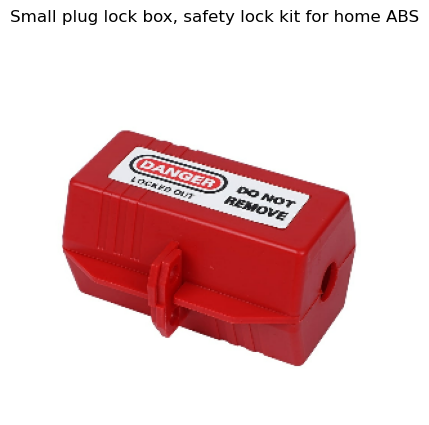

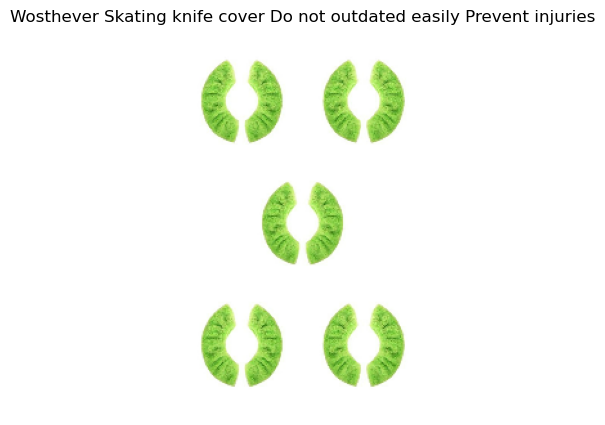

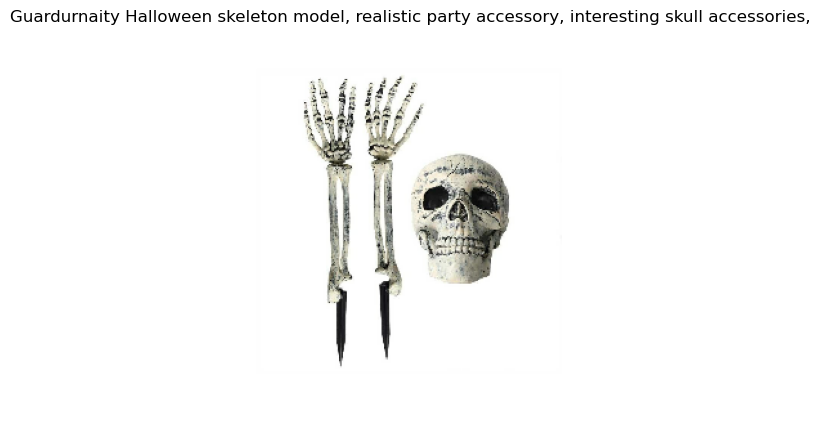

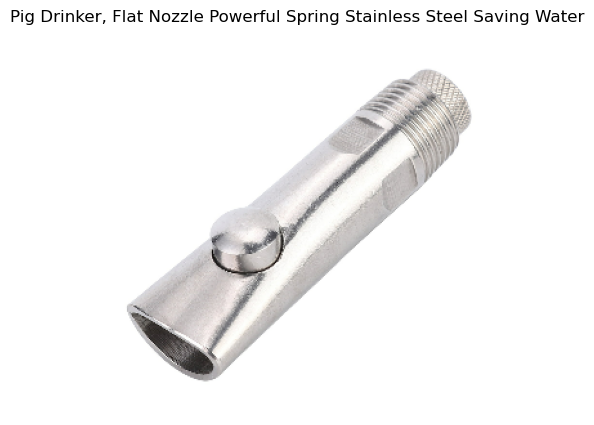

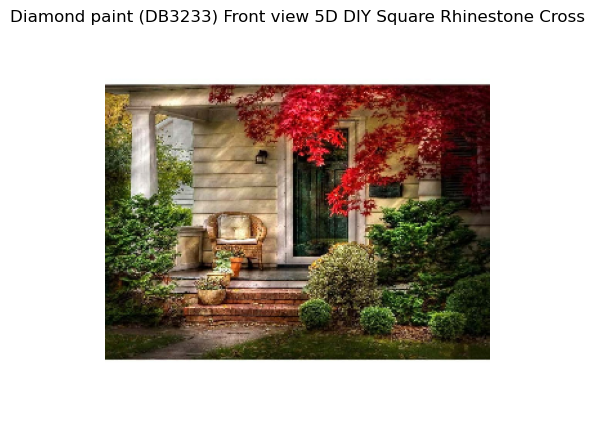

In [8]:
for image_path, caption in zip(image_paths[:5], captions):
    # Read the image file from S3
    image_content = tf.io.read_file(image_path)
    
    # Decode the image as a JPEG file
    image = tf.image.decode_jpeg(image_content, channels=3)
    
    # Convert image to float32 and scale the pixel values
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image
    image = tf.image.resize(image, [299, 299])

    # Convert it back to uint8
    image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    
    # Convert the TensorFlow tensor to a numpy array
    image_array = image.numpy()
    
    # Create a Pillow Image from the numpy array
    img = Image.fromarray(image_array)
    
    # Display the image with matplotlib
    plt.figure(figsize=(5, 5))  # Adjust the size as needed
    plt.imshow(img)
    plt.title(caption)  # Set the caption as the title of the plot
    plt.axis('off')  # Hide axes
    plt.show()
    

# Add Special Tokens

In [9]:
def add_start_end_token(caption):
    return f"<start> {caption} <end>"

In [10]:
captions_processed = [add_start_end_token(caption) for caption in captions]

In [11]:
MAX_CAPTION_LEN = 10


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(captions_processed)

In [12]:
sample_captions = []
for d in captions_processed[:5]:
    sample_captions.append(d)

In [13]:
print(tokenizer(sample_captions))

tf.Tensor(
[[    2   139   246   368    32   225   368    45     4    25]
 [    2    85  1645   696    11  5406  1145 17216  3484  2630]
 [    2   268   148  1485   135   958   118   114  1121  1433]
 [    2  2634  2339   462   386  1844   316    21    13   586]
 [    2    29    97 11679   193  2217    56    16   152   624]], shape=(5, 10), dtype=int64)


In [14]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [15]:
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    return image

def load_and_preprocess_image(file_path, caption):
    image = preprocess_image(file_path)
    return image, caption

def create_dataset(image_paths, captions):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def tokenize_and_prepare_targets(image, caption):
    # Tokenize the caption
    caption = tokenizer(caption)
    caption = tf.convert_to_tensor(caption, dtype=tf.int64)
    
    # Prepare the target by shifting the caption
    target = tf.roll(caption, shift=-1, axis=0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat([target[:-1], zeros], axis=0)
    
    return (image, caption), target


    # dataset = create_dataset(image_paths, captions)
    # dataset = dataset.map(tokenize_and_prepare_targets, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.batch(batch_size, drop_remainder=True)
    # dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
batch_size=32
dataset = create_dataset(image_paths, captions_processed)
dataset = dataset.map(tokenize_and_prepare_targets, num_parallel_calls=tf.data.AUTOTUNE)

# Split the dataset
validation_size = 1000
validation_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)

# Batch and prefetch the datasets
validation_batched_ds = validation_dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
train_batched_ds = train_dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
for (img, caption), label in train_batched_ds.take(1):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])


Image shape: (32, 299, 299, 3)
Caption shape: (32, 10)
Label shape: (32, 10)
tf.Tensor([   2  105  475   23 1828  196 1286  943 7160  211], shape=(10,), dtype=int64)
tf.Tensor([ 105  475   23 1828  196 1286  943 7160  211    0], shape=(10,), dtype=int64)


2024-06-13 09:50:06.804697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [19]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 8, 8, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1536)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 512)        │       786,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,123,680 (210.28 MB)

 Trainable params: 786,944 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Decoder

In [20]:
word_input = Input(shape=(MAX_CAPTION_LEN,), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

In [21]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ words (InputLayer)  │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 512)   │ 10,240,000 │ words[2][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 10, 512), │  1,575,936 │ embedding[2][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_1561C… │ (None, 64, 512)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 512)   │          0 │ gru[2][0],        │
│ (Attention)         │                   │            │ keras_tensor_156… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 512)   │          0 │ gru[2][0],        │
│                     │                   │            │ attention[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 512)   │      1,024 │ add[2][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 20000) │ 10,260,000 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,076,960 (84.22 MB)

 Trainable params: 22,076,960 (84.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

# Loss Functions

In [23]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [24]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

In [25]:
%%time
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = image_caption_train_model.fit(
    train_batched_ds,
    epochs=5,  # Set the number of epochs you want to train for
    validation_data=validation_batched_ds,
    callbacks=[early_stopping]
)

Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4183s 3s/step - loss: 6.5724 - val_loss: 5.5083
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4146s 3s/step - loss: 4.9315 - val_loss: 5.4010
Epoch 3/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4143s 3s/step - loss: 3.8582 - val_loss: 5.6358
Epoch 4/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4147s 3s/step - loss: 3.0577 - val_loss: 5.9767
Epoch 5/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4139s 3s/step - loss: 2.5127 - val_loss: 6.3629
CPU times: user 1d 11h 59min 10s, sys: 5h 30min 21s, total: 1d 17h 29min 32s
Wall time: 5h 45min 58s


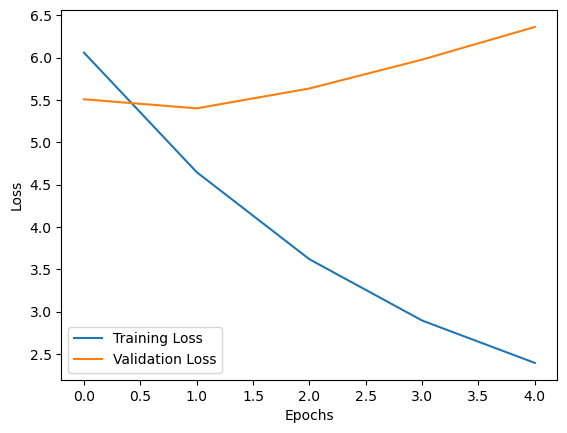

In [26]:
# Plot the history loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [27]:
gru_state_input = Input(shape=(ATTENTION_DIM,), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [28]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

********************
stainless steel kitchen utensils condiment rice baking tray barbecue.


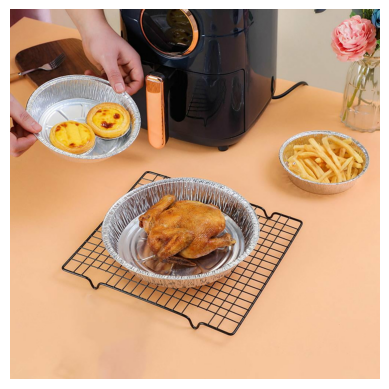

********************
monstrate stainless steel bottle cover lid bottle of vaco.


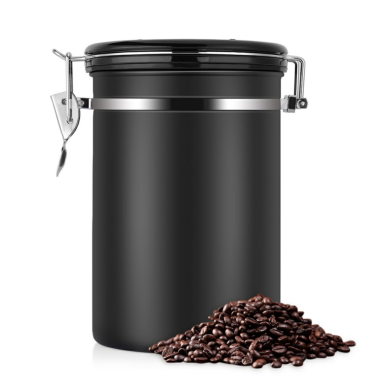

********************
2 tier handle stainless steel pot stand exhibit support.


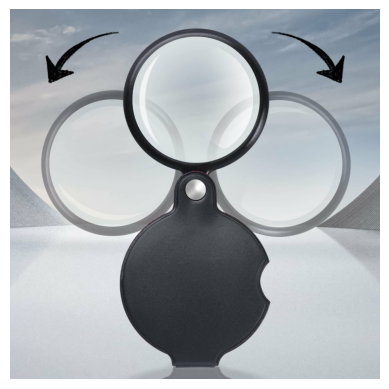

********************
stainless steel spring spring for children of summer mesh.


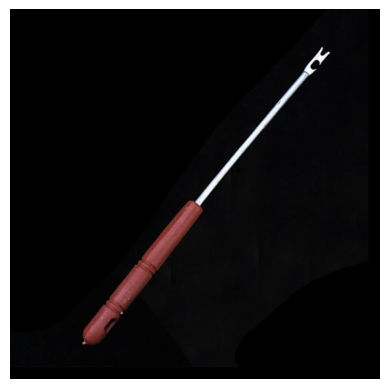

********************
diamond tester high hardness high sensitivity 5d diy round.


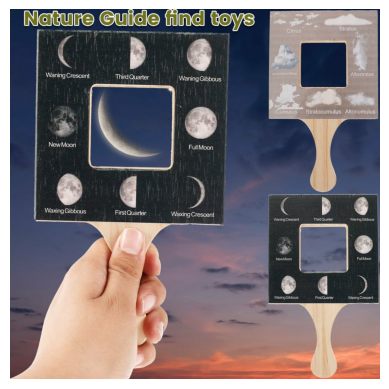

In [35]:
image_files = os.listdir("images") # you can also try surf.jpeg
image_files = [fn for fn in image_files if ".jpg" in fn]

for image_name in image_files:
    filename = "images/" + image_name
    image, caption = predict_caption(filename)
    print("*"*20)
    print(" ".join(caption[:-1]) + ".")

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Conclusion
The model validation loss does not reduce. However the training loss reduces at every epoch. This suggest that the model is indeed learning however it could not generalize to the validation dataset.

The main reason for this is that the dataset distribution is varse. There are too much product variety in these dataset. 

In order to scale it up, we could try to increase the number of image for training logarithmatically. In otherwords from 40k to 400k to check if the validation loss increases.